In [ ]:
#@title Initial setup of environment for running MMCLAB (run the below section once)

# Although you don't have to understand every command in this section, you do
# have to run this section once to set up the environment - it can take 4-5 mins
# to complete - just hit the run button, wait, and move on to the next section

######  Plan A - request Google Colab for a GPU and run CUDA based MCXLAB ######

# install octave and oct2py
!apt-get install octave      # install octave to Linux host
!apt-get install liboctave-dev # liboctave needed to install mmclab octave
!pip install oct2py          # install oct2py Python module

# MMC is run using openCL, we need to install this icd program to allow
# nvidia GPU compatibility with openCL
!apt-get install nvidia-opencl-icd-384

# download and install MMC
!git clone https://github.com/fangq/mmc.git

# compile MMC for octave
!make oct -C mmc/src

# download and unzip iso2mesh
!git clone https://github.com/fangq/iso2mesh.git

# download jsonlab and zmat toolboxes for sharing data between MATLAB and Python
!git clone https://github.com/fangq/jsonlab.git  # download jsonlab
!git clone https://github.com/NeuroJSON/zmat.git # download zmat


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aglfn default-jre-headless epstool fonts-droid-fallback fonts-freefont-otf fonts-noto-mono
  fonts-urw-base35 ghostscript gnuplot-data gnuplot-qt gsfonts imagemagick-6-common info
  install-info libamd2 libauthen-sasl-perl libbtf1 libcamd2 libccolamd2 libcholmod3 libclone-perl
  libcolamd2 libcombblas1.16.0 libcxsparse3 libdata-dump-perl libemf1 libencode-locale-perl
  libevdev2 libfftw3-double3 libfftw3-long3 libfftw3-mpi3 libfftw3-single3 libfile-listing-perl
  libfltk-gl1.3 libfltk1.3 libfont-afm-perl libglpk40 libglu1-mesa libgraphicsmagick++-q16-12
  libgraphicsmagick-q16-3 libgs9 libgs9-common libgudev-1.0-0 libhdf5-openmpi-103-1
  libhtml-form-perl libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl libhtml-tree-perl
  libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl

In [ ]:
# @title Add octave support to colab notebook (may need to be re-run after crashes)
#Add Octave support

# add octave support to colab notebook
%load_ext oct2py.ipython

In [ ]:
# @title Add paths in octave (same as adding folders in matlab)
%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc

addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh
addpath([pwd filesep 'jsonlab']);                % optional: add path to jsonlab for data export
addpath([pwd filesep 'zmat']);                   % optional: add path to zmat for data compression

In [ ]:
# @title Check installation of different packages in octave
%%octave
% check that mmclab is installed
help mmclab
% check that iso2mesh is installed
help dist2surf

% mmclab('gpuinfo')

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

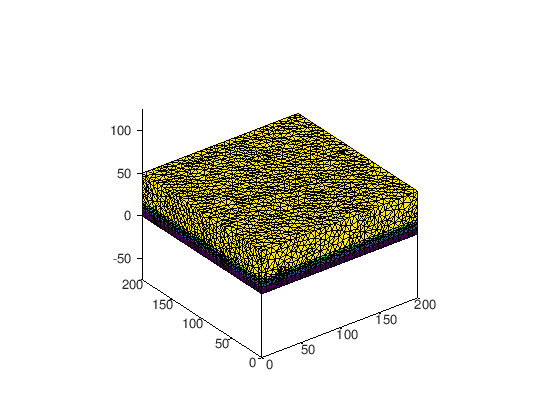

In [ ]:
# @title Prepare mesh for slab model of brain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh
addpath([pwd filesep 'jsonlab']);                % optional: add path to jsonlab for data export
addpath([pwd filesep 'zmat']);                   % optional: add path to zmat for data compression

% thickness of each layer in mm
TN=[7.25,4.00,2.73,3.29,4.23];

% prepare simulation mesh (a five layered slab):

% prepares a surface-only mesh:
[nodes,faces]=latticegrid([0 200],[0 200],[0 7.25 11.25 13.98 17.27 50]);
[nodes,faces]=latticegrid([0 200],[0 200],[0 TN(1,1) sum(TN(1,1:2)) sum(TN(1,1:3)) sum(TN(1,1:4)) 50]);

% plot the surface mesh to verify it is correct
%plotmesh(nodes, faces);

% prepares interior tetrahedrons for that mesh:
% max_volume is very important and determines our mesh density
% dramatically impacts performance:
max_volume = 100;

[nodes,elems]=surf2mesh(nodes,faces,[],[],1,max_volume,[1 1 4;1 1 9;1 1 12;1 1 14.5;1 1 25]);

% plot the tetrahedral mesh to verify it is correct:
plotmesh(nodes, elems);

In [ ]:
# @title Refine Tetrahedron sizes near the source
# this may be necessary when you are plotting near the source or want higher spatial resolution for fluence near the source (or any other feature)
# prevents performance issues from an otherwise large domain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh
addpath([pwd filesep 'jsonlab']);                % optional: add path to jsonlab for data export
addpath([pwd filesep 'zmat']);                   % optional: add path to zmat for data compression

centroids = meshcentroid(node, elem(:,1:4));

maxvols = ones(size(elems,1),1)*10;
% refine the size of tetrahedrons near the source if desired (not necessary in DMMC):
for i=1:size(elems,1)

    % Get elem centroid distance from source
    Dist = pdist([centroids(i,:);[100,100,0]], 'euclidean');
    dist(i) = Dist;
    % Refine elements based on distance to source
    if Dist<38
        maxvols(i)=4;
    elseif Dist<20
        maxvols(i)=2;
    end
end

UsageError: Cell magic `%%octave` not found.


In [ ]:
# @title Prepare and run MMC simulation

%% run the simulation
flux = mmclab(cfg_mmc);

%% save the resulting data:
save -mat7-binary sim_data flux cfg_mmc;



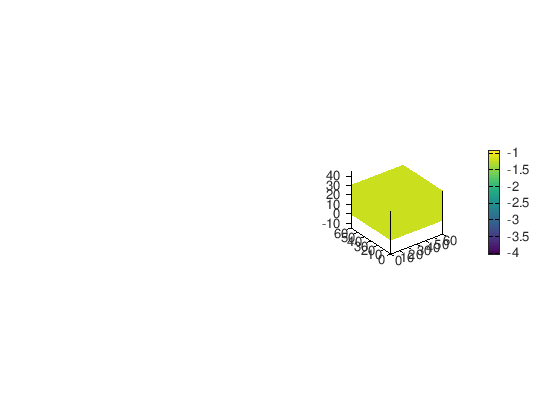

In [ ]:
%%octave

load sim_data

% plot the surface diffuse reflectance
if (isfield(cfg, 'issaveref') && cfg.issaveref == 1)
    subplot(122);
    faces = faceneighbors(cfg.elem, 'rowmajor');
    hs = plotmesh(cfg.node, faces, 'cdata', log10(flux.dref(:, 1)), 'linestyle', 'none');
    colorbar;
end